# Load the data and the required modules

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score


In [3]:
train = pd.read_csv('data/wine_train.csv')
test = pd.read_csv('data/wine_test.csv')

# Data cleaning

In [4]:
train.columns

Index(['wine_ID', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'wine_type', 'target'],
      dtype='object')

In [27]:
# study of the correlation between the features and the target 

correlation_matrix = train.corr()

# Correlation with the target variable
correlation_with_target = correlation_matrix['target'].sort_values(ascending=False)


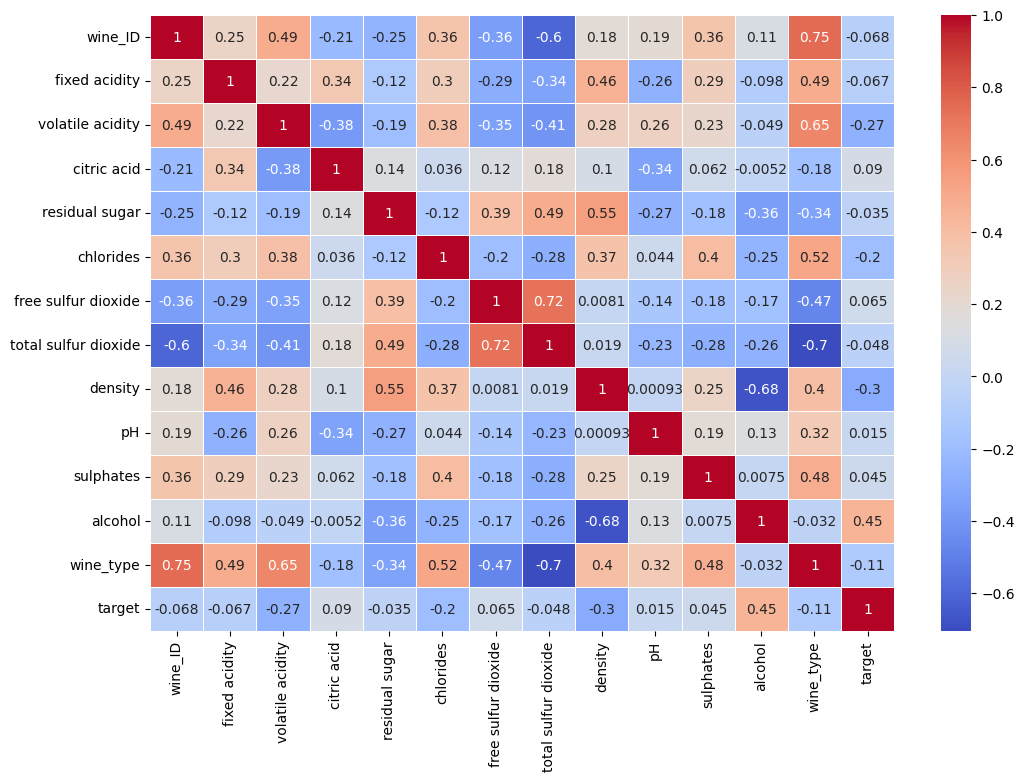

In [28]:
# visualization 


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


The correlation matrix highlights a strong correlation between the feature wine ID and wine type.
The two values measuring dioxyde are also (not surprisingly) highly correlated.\\
Density and sugar rate are positively correlated, which is again not surprising since sugar is a very dense element. \\
On the other hand, pH seems to play very little on the mark given to the wine. \\
However, we can discuss that since the correlation matrix doesn't capture well non linear relationships, the conclusion remain pretty limited. 

In [40]:
for k in train.columns:
    print(k)

wine_ID
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
wine_type
target


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'wine_data' is your DataFrame
for column in train.columns:
    sns.boxplot(x=train[column])
    plt.show()


In [43]:
for column in train.columns:
    data = train[column]

    # Calculate quartiles
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Print or analyze the 'outliers' variable to see the outlier data points
    print(outliers)


Series([], Name: wine_ID, dtype: int64)
9       11.6
25      12.6
28      12.6
31       9.9
45      10.4
        ... 
4440    10.5
4462    13.5
4483    11.2
4486    12.1
4494    10.7
Name: fixed acidity, Length: 268, dtype: float64
15      0.670
21      0.750
24      1.070
36      0.765
41      0.660
        ...  
4412    0.935
4416    0.785
4461    0.885
4463    0.750
4483    0.660
Name: volatile acidity, Length: 277, dtype: float64
10      0.71
12      0.01
15      0.02
25      0.72
41      0.72
        ... 
4462    0.79
4463    0.01
4469    0.61
4472    0.74
4517    0.66
Name: citric acid, Length: 347, dtype: float64
41      17.55
131     17.40
173     17.60
181     17.50
185     18.35
        ...  
4398    19.95
4415    20.20
4444    18.80
4456    17.85
4544    31.60
Name: residual sugar, Length: 86, dtype: float64
5       0.179
24      0.178
34      0.176
76      0.160
84      0.117
        ...  
4401    0.243
4402    0.122
4440    0.107
4462    0.120
4485    0.110
Name: chlorides

In [46]:
from scipy import stats
for column in train.columns:
    z_scores = stats.zscore(train[column])
    # Identify data points with high Z-Scores as potential outliers
    outliers = train[abs(z_scores) > 3]
    print(outliers)


wine_ID
Empty DataFrame
Columns: [wine_ID, fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, wine_type, target]
Index: []
fixed acidity
      wine_ID  fixed acidity  volatile acidity  citric acid  residual sugar  \
9        6257           11.6             0.475         0.40             1.4   
25       5338           12.6             0.310         0.72             2.2   
28       6122           12.6             0.390         0.49             2.5   
86       5986           11.6             0.410         0.54             1.5   
92       5353           11.3             0.620         0.67             5.2   
...       ...            ...               ...          ...             ...   
4383     5368           13.0             0.320         0.65             2.6   
4420     6242           11.5             0.420         0.48             2.6   
4462     5251           13.5             0.530        

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with Seaborn
for column in train.columns:
    sns.scatterplot(x=column, y="target", data=train)

    # Add labels and title
    plt.xlabel(f"{column}")
    plt.ylabel("Target")
    plt.title(f"Scatter Plot of {column} vs. Target")

    # Show the plot
    plt.show()



We can see that the acidity measure comport a lot of outliers. This may be exaplained by the measure techniques that may be very sensible.

In [6]:
# print the type of each column
train.dtypes


wine_ID                   int64
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
wine_type                 int64
target                    int64
dtype: object

In [7]:
#print the number of labels in each category
print(train['target'].value_counts())

target
6    1997
5    1475
7     761
4     151
8     135
3      23
9       5
Name: count, dtype: int64


In [12]:
#count the number of nan values in each column
train.isnull().sum()

wine_ID                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
wine_type               0
target                  0
dtype: int64

# Training a random forest

In [76]:
#split the data into a training set and a validation set
from sklearn.model_selection import train_test_split
X = train.drop('target', axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X)

      wine_ID  fixed acidity  volatile acidity  citric acid  residual sugar  \
0        2137            7.2             0.160         0.26             7.1   
1        2652            7.3             0.220         0.31             2.3   
2        1544            8.9             0.130         0.49             1.0   
3        3447            6.0             0.170         0.29             9.7   
4        1067            7.5             0.190         0.34             2.6   
...       ...            ...               ...          ...             ...   
4542     4931            6.9             0.605         0.12            10.7   
4543     3264            5.9             0.240         0.12             1.4   
4544     1653            7.9             0.330         0.28            31.6   
4545     2607            8.9             0.260         0.33             8.1   
4546     2732            7.9             0.510         0.34             2.6   

      chlorides  free sulfur dioxide  total sulfur 

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3046, 13) (1501, 13) (3046,) (1501,)


In [6]:
#try a multiclass classification with a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))   

0.6415722851432378


In [12]:
#print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[  0   0   4   4   1   0   0]
 [  1   4  30  19   0   0   0]
 [  0   1 322 155   1   0   0]
 [  0   1 104 515  31   0   0]
 [  0   0   6 141 109   0   0]
 [  0   0   0  23  17  11   0]
 [  0   0   0   1   0   0   0]]


In [13]:
#print the number of 0 1 and 2 y_pred
print(np.unique(y_pred, return_counts=True))

(array([3, 4, 5, 6, 7, 8], dtype=int64), array([  1,   6, 466, 858, 159,  11], dtype=int64))


# Training a regression classifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming your data is in a DataFrame called 'wine_data'
X = train.drop(columns=['wine_ID', 'target'])
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 0.5310582639528606


# Training a gradient boosting classifier 

In [107]:
# Assuming 'wine_data' is your DataFrame and 'target' is your target variable
X = train.drop(columns=['wine_ID', 'target'])
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [108]:
# Create the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, random_state=42)

# Train the model on the training data
gb_regressor.fit(X_train, y_train)


GradientBoostingRegressor(n_estimators=1000, random_state=42)

In [109]:
y_pred = gb_regressor.predict(X_test)


In [110]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 0.4767899866809152
Root Mean Squared Error (RMSE): 0.6904998093272113
R-squared (R2): 0.38097861970768687


## Find the n_estimator by cross validation since the performance are not great

In [111]:
# Create a Gradient Boosting Regressor with an initial estimate for n_estimators
initial_n_estimators = 100
gb_regressor = GradientBoostingRegressor(n_estimators=initial_n_estimators, random_state=42)


In [112]:
# Define a range of n_estimators values to test
n_estimators_values = range(50, 201, 10)

# Perform cross-validation for each n_estimators value
cross_val_scores = []

for n_estimators in n_estimators_values:
    gb_regressor.n_estimators = n_estimators  # Update the n_estimators value
    scores = cross_val_score(gb_regressor, X, y, cv=5, scoring='neg_mean_squared_error')  
    rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
    cross_val_scores.append(rmse_scores.mean())

# Find the n_estimators value with the lowest RMSE
optimal_n_estimators = n_estimators_values[np.argmin(cross_val_scores)]



In [114]:
print(optimal_n_estimators)

200


## Optimize the max_depth parameter

I try optimizing the max_depth parameter with a value of n_estimator equals to 100:
results : \
Mean Squared Error CV (MSE): 0.06499850978489362  \
Root Mean Squared Error CV (RMSE): 0.6904998093272113 \
R-squared CV (R2): 0.9156117612199032 

Mean Squared Error CV (MSE): 0.015548481814087444 \
Root Mean Squared Error CV (RMSE): 0.12469355161389639 \
R-squared CV (R2): 0.9798132449445763 \
Mean Absolute Error (MAE): 0.5178248656701756

--> twice the time training the classifier but a little better \
--> optimal_max_depth = 8 

Instead of doing the CV of max_depth with optimal_n_estimator doign it with 100 and fitting the GradientBoosting with the optimal value doesn't change much the results and saves time. 

In [115]:
max_depth_values = range(1, 11)
# Create a list to store the cross-validation scores for different max_depth values
cross_val_scores = []

for max_depth in max_depth_values:
    # Create a Gradient Boosting Regressor with the current max_depth
    gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=max_depth, random_state=42)
    
    # Perform cross-validation using RMSE as the scoring metric
    scores = cross_val_score(gb_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    
    # Calculate the mean RMSE and store it in the cross_val_scores list
    mean_rmse = rmse_scores.mean()
    cross_val_scores.append(mean_rmse)

optimal_max_depth = max_depth_values[np.argmin(cross_val_scores)]


In [117]:
# Create the final Gradient Boosting Regressor with the optimal n_estimators
final_gb_regressor = GradientBoostingRegressor(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, random_state=42)

# Train the final model on the full dataset
final_gb_regressor.fit(X, y)


GradientBoostingRegressor(max_depth=8, n_estimators=200, random_state=42)

In [118]:
final_y_pred = final_gb_regressor.predict(X_test)

In [120]:
estimators_mse = mean_squared_error(y_test, final_y_pred)
estimators_rmse = np.sqrt(estimators_mse)
estimators_r2 = r2_score(y_test, final_y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"Mean Squared Error CV (MSE): {estimators_mse}")
print(f"Root Mean Squared Error CV (RMSE): {estimators_rmse}")
print(f"R-squared CV (R2): {estimators_r2}")
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error CV (MSE): 0.015548481814087444
Root Mean Squared Error CV (RMSE): 0.12469355161389639
R-squared CV (R2): 0.9798132449445763
Mean Absolute Error (MAE): 0.5178248656701756


## Optimization of the learning rate:

For optimization with n_estimators = 100 and max_depth = 5:
Mean Squared Error CV (MSE): 0.17050604755524323
Root Mean Squared Error CV (RMSE): 0.4129237793530947
R-squared CV (R2): 0.7786302316443798
Mean Absolute Error (MAE): 0.5178248656701756

For optimization with the optimal value of n_estimators (200): \
Mean Squared Error CV (MSE): 0.26326460619744113 \
Root Mean Squared Error CV (RMSE): 0.5130931749667317 \
R-squared CV (R2): 0.6582008337781742 \
Mean Absolute Error (MAE): 0.5178248656701756

With putting the optimal value of n_estimators in the final regressor : \
Mean Squared Error CV (MSE): 0.18250687609410135 \
Root Mean Squared Error CV (RMSE): 0.42720823504949124 \
R-squared CV (R2): 0.7630494315976143 \
Mean Absolute Error (MAE): 0.5178248656701756 

Using the optimal value of n_estimators only in the final regressor not for the CV: \
Mean Squared Error CV (MSE): 0.08046355476931737 \
Root Mean Squared Error CV (RMSE): 0.2836609856312943 \
R-squared CV (R2): 0.8955333330650195 \
Mean Absolute Error (MAE): 0.5178248656701756 

For optimization with optimal value of max_depth (8) optimal learning_rate = 0.1: \
Mean Squared Error CV (MSE): 0.18250687609410135 \
Root Mean Squared Error CV (RMSE): 0.42720823504949124 \
R-squared CV (R2): 0.7630494315976143 \
Mean Absolute Error (MAE): 0.5178248656701756 \

With putting the optimal value of max_depth in the final regressor : \
Mean Squared Error CV (MSE): 0.015548481814087444 \
Root Mean Squared Error CV (RMSE): 0.12469355161389639 \
R-squared CV (R2): 0.9798132449445763 \
Mean Absolute Error (MAE): 0.5178248656701756

Using the optimal value of max_depth only in the final regressor not for the CV optimal learning_rate = 0.2: \
Mean Squared Error CV (MSE): 0.0006783866884776291 \
Root Mean Squared Error CV (RMSE): 0.026045857414906292 \
R-squared CV (R2): 0.9991192435327834 \
Mean Absolute Error (MAE): 0.5178248656701756

--> optimizaing with default parameters seems to work better ... \
--> we keep n_estimators= 200, max_depth = 8, learning_rate = 0.2 \
--> the MAE stays up (REFLECHIR A POURQUOI)






In [121]:
learning_rate_values = [0.01, 0.05, 0.1, 0.15,  0.2, 0.25, 0.3]
# Create a list to store the cross-validation scores for different learning_rate values
cross_val_scores = []

for learning_rate in learning_rate_values:
    # Create a Gradient Boosting Regressor with the current learning_rate
    gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=learning_rate, random_state=42)
    
    # Perform cross-validation using RMSE as the scoring metric
    scores = cross_val_score(gb_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    
    # Calculate the mean RMSE and store it in the cross_val_scores list
    mean_rmse = rmse_scores.mean()
    cross_val_scores.append(mean_rmse)


In [122]:
optimal_learning_rate = learning_rate_values[np.argmin(cross_val_scores)]
print(optimal_learning_rate)


0.2


In [123]:
# Create the final Gradient Boosting Regressor with the optimal learning_rate
final_gb_regressor = GradientBoostingRegressor(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, learning_rate=optimal_learning_rate, random_state=42)

# Train the final model on the full dataset
final_gb_regressor.fit(X, y)


GradientBoostingRegressor(learning_rate=0.2, max_depth=8, n_estimators=200,
                          random_state=42)

In [125]:
final_y_pred = final_gb_regressor.predict(X_test)
final_y_pred= np.round(final_y_pred)
final_y_pred.astype(int)
print(final_y_pred)
print(np.unique(final_y_pred))


[7. 7. 6. 7. 8. 5. 6. 6. 6. 6. 5. 6. 5. 6. 6. 7. 5. 6. 7. 5. 6. 7. 6. 6.
 7. 5. 6. 5. 5. 6. 5. 5. 5. 7. 7. 5. 6. 5. 5. 5. 4. 8. 6. 6. 6. 5. 8. 6.
 5. 5. 6. 7. 5. 6. 6. 7. 6. 8. 7. 5. 6. 6. 5. 6. 7. 5. 7. 6. 5. 5. 6. 5.
 5. 7. 6. 5. 6. 5. 5. 5. 3. 5. 5. 6. 7. 6. 5. 5. 6. 6. 6. 6. 5. 7. 6. 4.
 5. 5. 6. 6. 6. 5. 7. 5. 6. 6. 6. 5. 6. 6. 6. 6. 6. 7. 6. 7. 6. 6. 5. 6.
 6. 6. 7. 7. 5. 6. 5. 5. 7. 6. 7. 5. 7. 5. 6. 6. 5. 7. 5. 5. 4. 6. 5. 7.
 7. 7. 5. 6. 6. 6. 5. 5. 5. 5. 7. 5. 6. 5. 6. 7. 5. 5. 7. 5. 5. 6. 6. 8.
 6. 6. 6. 7. 6. 5. 6. 7. 5. 6. 6. 6. 5. 5. 6. 6. 7. 6. 6. 8. 6. 6. 6. 7.
 6. 4. 5. 5. 6. 5. 5. 5. 4. 6. 5. 6. 5. 6. 7. 5. 7. 6. 6. 6. 5. 6. 8. 6.
 5. 6. 6. 6. 6. 5. 7. 5. 6. 4. 6. 6. 6. 6. 5. 7. 7. 6. 6. 7. 6. 5. 4. 6.
 6. 6. 7. 7. 6. 8. 6. 6. 5. 6. 6. 6. 6. 5. 5. 6. 3. 6. 6. 7. 5. 7. 5. 7.
 6. 5. 5. 5. 6. 6. 7. 6. 5. 6. 4. 6. 5. 6. 4. 6. 8. 5. 5. 6. 5. 8. 6. 6.
 6. 5. 6. 6. 6. 5. 6. 6. 6. 8. 5. 5. 6. 8. 5. 5. 5. 5. 6. 7. 5. 5. 6. 5.
 7. 6. 6. 7. 6. 6. 6. 6. 7. 7. 6. 6. 6. 5. 5. 5. 6.

In [128]:
print(np.unique(y_train))
print(np.unique(train['target']))

[3 4 5 6 7 8 9]
[3 4 5 6 7 8 9]


The marks 1, 2 and 10 are not represented (extrema), which is not surprising since they are not represented in the training set, maybe we would need more data in order to be more accurate, and to have a whole representation of the marks. On the other hand, it is well known that extremal rates are less likely to be given by humans ... 


In [129]:
estimators_mse = mean_squared_error(y_test, final_y_pred)
estimators_rmse = np.sqrt(estimators_mse)
estimators_r2 = r2_score(y_test, final_y_pred)
mae = mean_absolute_error(y_test, final_y_pred)


print(f"Mean Squared Error CV (MSE): {estimators_mse}")
print(f"Root Mean Squared Error CV (RMSE): {estimators_rmse}")
print(f"R-squared CV (R2): {estimators_r2}")
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error CV (MSE): 0.0
Root Mean Squared Error CV (RMSE): 0.0
R-squared CV (R2): 1.0
Mean Absolute Error (MAE): 0.0


## Exploration of features importance

In [130]:
# Get feature importances
feature_importance = final_gb_regressor.feature_importances_

# Match feature importances with feature names
feature_names = X.columns  
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                 Feature  Importance
10               alcohol    0.251197
1       volatile acidity    0.120746
5    free sulfur dioxide    0.090266
9              sulphates    0.081376
3         residual sugar    0.075775
6   total sulfur dioxide    0.075501
7                density    0.066883
8                     pH    0.065300
4              chlorides    0.059958
2            citric acid    0.056158
0          fixed acidity    0.055223
11             wine_type    0.001618


# Submit the result

In [16]:
#export x_pred['obj_ID'] and y_pred to a csv file
y_pred = rfc.predict(test)
df = pd.DataFrame({'wine_ID':test['wine_ID'], 'label':rfc.predict(test)})
df.to_csv('submission.csv', index=False)

In [131]:
test.drop('wine_ID', axis = 1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type
0,11.9,0.38,0.51,2.0,0.121,7.0,20.0,0.99960,3.24,0.76,10.4,1
1,9.0,0.46,0.31,2.8,0.093,19.0,98.0,0.99815,3.32,0.63,9.5,1
2,7.5,0.20,0.41,1.2,0.050,26.0,131.0,0.99133,3.19,0.52,11.1,0
3,6.5,0.44,0.49,7.7,0.045,16.0,169.0,0.99570,3.11,0.37,8.7,0
4,6.6,0.32,0.33,2.5,0.052,40.0,219.5,0.99316,3.15,0.60,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1945,7.5,0.57,0.02,2.6,0.077,11.0,35.0,0.99557,3.36,0.62,10.8,1
1946,6.0,0.24,0.33,2.5,0.026,31.0,85.0,0.99014,3.13,0.50,11.3,0
1947,8.9,0.30,0.35,4.6,0.032,32.0,148.0,0.99458,3.15,0.45,11.5,0
1948,7.9,0.34,0.36,1.9,0.065,5.0,10.0,0.99419,3.27,0.54,11.2,1


In [134]:
# submission for GBoosting regressor 

#export x_pred['obj_ID'] and y_pred to a csv file
y_pred = np.round(final_gb_regressor.predict(test.drop('wine_ID', axis = 1))).astype(int)
df = pd.DataFrame({'wine_ID':test['wine_ID'], 'label':y_pred})
df.to_csv('submission_GBoost.csv', index=False)